**Performing first trials in jupyter for Tyne and Wear**

_at LSOA level!_

**1. Variables declarations**

NB: to be edited depending on who runs this

In [47]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import os.path

# system paths
output_folder = "./../output/" # folder where results will be stored
# add one for input and/or data folder to be used when calling data below
# then can create file paths with os.path.join

# selected region specific files
msoa_full_file = "./../data/MSOAs_TyneWear_full.csv" # lut table with names, codes etc for MSOAs with LADS
msoa_list_file = "./../data/MSOAs_TyneWear.csv" # simple list of MSOAs codes (example "E02001682")
lad_list_file = "./../data/LADs_TyneWear.csv" # table with code and name of LADs (example "1","E08000037","Gateshead")
# note: we obtain the LSOAs list for the region later on, starting from the region LAD list file
# in fact the house price file is at LSOA level, therefore the first analyses will be at LSOA level

# national level files
house_prices_lsoa_xls_file = "./../data/hpssadataset46medianpricepaidforresidentialpropertiesbylsoa.xls" # excel spreadsheet downloaded from gov website (see Notes) with median house prices, quarterly data from Dec 1995

greenspace_file = "./../data/gis/OS Open Greenspace (GPKG) GB/data/opgrsp_gb.gpkg" # geopackage file with greenspace areas + access points from OS

# administrative division files
LSOA_boundaries_file = "./../data/gis/LSOA_(Dec_2011)_Boundaries_Super_Generalised_Clipped_(BSC)_EW_V3/" # administrative boundaries from gov.uk OS
MSOA_boundaries_file = ""

**2. Variables import**

A. Tables import

In [3]:
msoas_full_df = pd.read_csv(msoa_full_file)
msoas_list_df = pd.read_csv(msoa_list_file)
lad_list_df = pd.read_csv(lad_list_file)

houseprice_excel_tab = pd.read_excel(house_prices_lsoa_xls_file,
                                     sheet_name = "Data") # name of excel tab within the spreadsheet which contains our desired data


some data edits

In [4]:
# editing the dataframe (contains empty rows and other un-necessary stuff inherited from excel)
# a. first 4 rows are empty
# b. 5th row contains the columns names

houseprice_df_notitle = houseprice_excel_tab.iloc[4:] # eliminating first 4 rows
houseprice_df_notitle.columns = houseprice_df_notitle.iloc[0] # attributing columns names from current first row
houseprice_df = houseprice_df_notitle.iloc[1:] # eliminating first row (with names)

# note: think to edit this when reading the file in, already,as in
# https://stackoverflow.com/questions/48036296/using-read-excel-with-converters-for-reading-excel-file-into-pandas-dataframe-re

# checking data type for columns with numerical values
houseprice_df.iloc[:, 0:6].dtypes
# we have a total of 113 columns, checking the last 6 ones
houseprice_df.iloc[:,-6: ].dtypes
# let's eliminate the last 3 columns (empty?)
houseprice_df = houseprice_df.iloc[ : , :-3]
houseprice_df.iloc[:,-6: ].dtypes
# numerical values are read in a type 'object', but we can't change this in the reading command above:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html
# in fact 'dtype' option changes it for all the columns
# so we do that only after import, here:

4
Year ending Dec 2020    object
Year ending Mar 2021    object
Year ending Jun 2021    object
Year ending Sep 2021    object
Year ending Dec 2021    object
Year ending Mar 2022    object
dtype: object

In [5]:
colnames_houseprice = houseprice_df.columns.to_list()
numerical_colnames = colnames_houseprice[4:] # selecting only names names of the columns that contain numerical values

In [6]:
# houseprice_df.head()
# # changing type to numeric for columns from position 4 to end
# # houseprice_df.iloc[:,4:].apply(pd.to_numeric, errors='coerce')
# # houseprice_df.iloc[:,4:].astype(float)
# # houseprice_df.iloc[:,4:] = pd.to_numeric(houseprice_df.iloc[:,4:].stack(),
# #                                          errors='coerce').unstack()
# numerical_cols = houseprice_df.columns.str.startswith('Year ending')
# # object_cols = ~houseprice_df.columns.str.startswith('Year ending')
# houseprice_df.loc[:,houseprice_df.columns.str.startswith('Year ending')]

In [7]:
houseprice_df[numerical_colnames] = houseprice_df[numerical_colnames].apply(pd.to_numeric,
                                                                            errors='coerce')
houseprice_df.iloc[:,-6:].dtypes # worked
# https://stackoverflow.com/questions/36814100/pandas-to-numeric-for-multiple-columns

4
Year ending Dec 2020    float64
Year ending Mar 2021    float64
Year ending Jun 2021    float64
Year ending Sep 2021    float64
Year ending Dec 2021    float64
Year ending Mar 2022    float64
dtype: object

selecting region (case: Tyne and Wear county)

In [8]:
# NOTE: the common field between the house price file and regional file (administrative division) is the LAD codes list
# the field is called "LAD20CD" in the lads list file, and "Local authority code" in the house price file
region_LADs_codes_list = lad_list_df["LAD20CD"].to_numpy()

# generating list of LSOAs code for the region
#
# generating list of MSOAs code for the region
#

houseprice_lsoa_region = houseprice_df[houseprice_df["Local authority code"].isin(region_LADs_codes_list)]
houseprice_lsoa_region.dtypes

4
Local authority code     object
Local authority name     object
LSOA code                object
LSOA name                object
Year ending Dec 1995    float64
                         ...   
Year ending Mar 2021    float64
Year ending Jun 2021    float64
Year ending Sep 2021    float64
Year ending Dec 2021    float64
Year ending Mar 2022    float64
Length: 110, dtype: object

In [9]:
# dataframe with LSOAs code and name for the region
lsoas_region_list = houseprice_lsoa_region[["LSOA code", "LSOA name"]]
# creating the list of the region codes for indexing (filtering) purposes (it is an array)
lsoas_region_codes = lsoas_region_list["LSOA code"].to_numpy()

B. Importing geospatial data

In [10]:
# importing greenspace (gpkg)
# note, available layers are: "GreenspaceSite" (green areas) and "AccessPoint" (actual access points)
greenspace = gpd.read_file(greenspace_file,
                           layer = "GreenspaceSite")
greenspace.head() 

,id,function,distinctiveName1,distinctiveName2,distinctiveName3,distinctiveName4,geometry
0,idE56DE736-A177-13A9-E053-AAEFA00A0D0E,Cemetery,None,None,None,None,"MULTIPOLYGON (((461903.000 1202925.500, 461894..."
1,idE56DE70E-AB4D-13A9-E053-AAEFA00A0D0E,Cemetery,None,None,None,None,"MULTIPOLYGON (((456682.070 1204040.270, 456711..."
2,idE56DE70E-A916-13A9-E053-AAEFA00A0D0E,Cemetery,None,None,None,None,"MULTIPOLYGON (((453155.070 1204881.760, 453160..."
3,idE56DE70E-A769-13A9-E053-AAEFA00A0D0E,Religious Grounds,St John's Kirk,None,None,None,"MULTIPOLYGON (((461466.140 1208820.310, 461489..."
4,idE56DE6C9-C6CF-13A9-E053-AAEFA00A0D0E,Play Space,None,None,None,None,"MULTIPOLYGON (((462261.310 1208879.400, 462245..."


<AxesSubplot:>

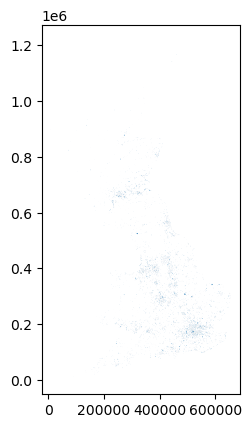

In [11]:
greenspace.plot()

In [12]:
accesspoints_gs = gpd.read_file(greenspace_file,
                           layer = "AccessPoint")
accesspoints_gs.head() 

,id,accessType,refToGreenspaceSite,geometry
0,idB91D85B1-DEE3-47D6-805A-CD6B9ACF4C4F,Pedestrian,idE56DE70E-AB4D-13A9-E053-AAEFA00A0D0E,POINT (456682.070 1204040.270)
1,id4A6E7947-0AFE-48E3-8D42-D4FD1EF4FDEE,Pedestrian,idE56DE70E-A916-13A9-E053-AAEFA00A0D0E,POINT (453155.070 1204881.760)
2,id2614EF8D-E649-4A9F-86F2-95E248B38AFB,Motor Vehicle And Pedestrian,idE56DE70E-A769-13A9-E053-AAEFA00A0D0E,POINT (461466.140 1208820.310)
3,idCC4DDC12-0AE9-4023-A7FE-DE064614A1DC,Pedestrian,idE56DE6C9-C6CF-13A9-E053-AAEFA00A0D0E,POINT (462261.310 1208879.400)
4,idB616B7A5-140F-4564-BDC0-A5AAF61E51AC,Motor Vehicle And Pedestrian,idE56DE70E-A700-13A9-E053-AAEFA00A0D0E,POINT (460892.660 1208953.160)


<AxesSubplot:>

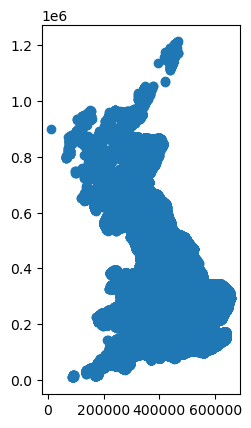

In [13]:
accesspoints_gs.plot()

In [14]:
# importing LSOA admin boundaries (shp or json) nationwide
lsoas_shp = gpd.read_file(LSOA_boundaries_file)
lsoas_shp.head()

,OBJECTID,LSOA11CD,LSOA11NM,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,GlobalID,geometry
0,1,E01000001,City of London 001A,City of London 001A,532129,181625,-0.097060,51.51810,157794.481079,1685.391778,b12173a3-5423-4672-a5eb-f152d2345f96,"POLYGON ((532282.629 181906.496, 532248.250 18..."
1,2,E01000002,City of London 001B,City of London 001B,532480,181699,-0.091970,51.51868,164882.427628,1804.828196,90274dc4-f785-4afb-95cd-7cc1fc9a2cad,"POLYGON ((532746.814 181786.892, 532248.250 18..."
2,3,E01000003,City of London 001C,City of London 001C,532245,182036,-0.095230,51.52176,42219.805717,909.223277,7e89d0ba-f186-45fb-961c-8f5ffcd03808,"POLYGON ((532293.068 182068.422, 532419.592 18..."
3,4,E01000005,City of London 001E,City of London 001E,533581,181265,-0.076280,51.51452,212682.404259,2028.654904,a14c307a-874c-4862-828a-3b1486cc21ea,"POLYGON ((533604.245 181418.129, 533743.689 18..."
4,5,E01000006,Barking and Dagenham 016A,Barking and Dagenham 016A,544994,184276,0.089318,51.53876,130551.387161,1716.896118,65121a2d-3d2b-4935-9712-690f2993cfd2,"POLYGON ((545271.918 184183.948, 545296.314 18..."


In [15]:
# selecting LSOAs for our region
lsoas_shp_region = lsoas_shp.query('LSOA11CD in @lsoas_region_codes')

<AxesSubplot:>

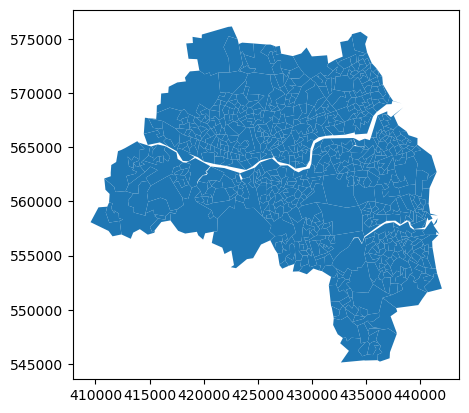

In [16]:
lsoas_shp_region.plot()

**3. Data analysis**

Associating data to geospatial data (or viceversa, adding geography to data)

In [17]:
# searching for common field between the 2 tables (we need this for the merge operation right after)
houseprice_lsoa_region.columns

Index(['Local authority code', 'Local authority name', 'LSOA code',
       'LSOA name', 'Year ending Dec 1995', 'Year ending Mar 1996',
       'Year ending Jun 1996', 'Year ending Sep 1996', 'Year ending Dec 1996',
       'Year ending Mar 1997',
       ...
       'Year ending Dec 2019', 'Year ending Mar 2020', 'Year ending Jun 2020',
       'Year ending Sep 2020', 'Year ending Dec 2020', 'Year ending Mar 2021',
       'Year ending Jun 2021', 'Year ending Sep 2021', 'Year ending Dec 2021',
       'Year ending Mar 2022'],
      dtype='object', name=4, length=110)

In [18]:
lsoas_shp_region.columns

Index(['OBJECTID', 'LSOA11CD', 'LSOA11NM', 'LSOA11NMW', 'BNG_E', 'BNG_N',
       'LONG', 'LAT', 'Shape__Are', 'Shape__Len', 'GlobalID', 'geometry'],
      dtype='object')

In [19]:
# lsoa_gdf_with_houseprice = lsoas_shp_region.merge(houseprice_lsoa_region, 
#                                                   on='')
lsoa_gdf_region_with_houseprice = pd.merge(lsoas_shp_region,
                                           houseprice_lsoa_region,
                                           left_on='LSOA11CD',
                                           right_on="LSOA code")

In [20]:
lsoa_gdf_region_with_houseprice.columns

lsoa_gdf_region_with_houseprice.iloc[:, 118:124].dtypes # checking type of column
# ... actually price is an 'object' type ... converting it earlier on

Year ending Jun 2021    float64
Year ending Sep 2021    float64
Year ending Dec 2021    float64
Year ending Mar 2022    float64
dtype: object

plotting map... trials

<AxesSubplot:>

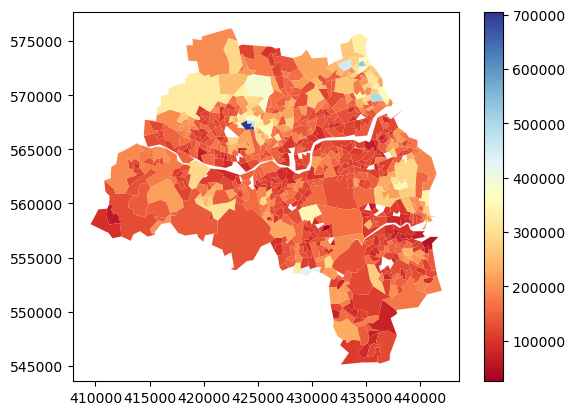

In [21]:
# define legend keys (not used)
lgnd_kwds = {'title': 'Median house price per area',
             'loc': 'upper right',
             'bbox_to_anchor': (1.8, 1)}

lsoa_gdf_region_with_houseprice.plot(column="Year ending Mar 2022",
                                     cmap="RdYlBu",
                                     legend=True)

<mark>#TO_DO:</mark>

- [X] plot also greenspaces and network on top of this

- [X] can we plot a facet graphing (like in R) of the above plot for different time slots? _yes, with pyplot.subplots_


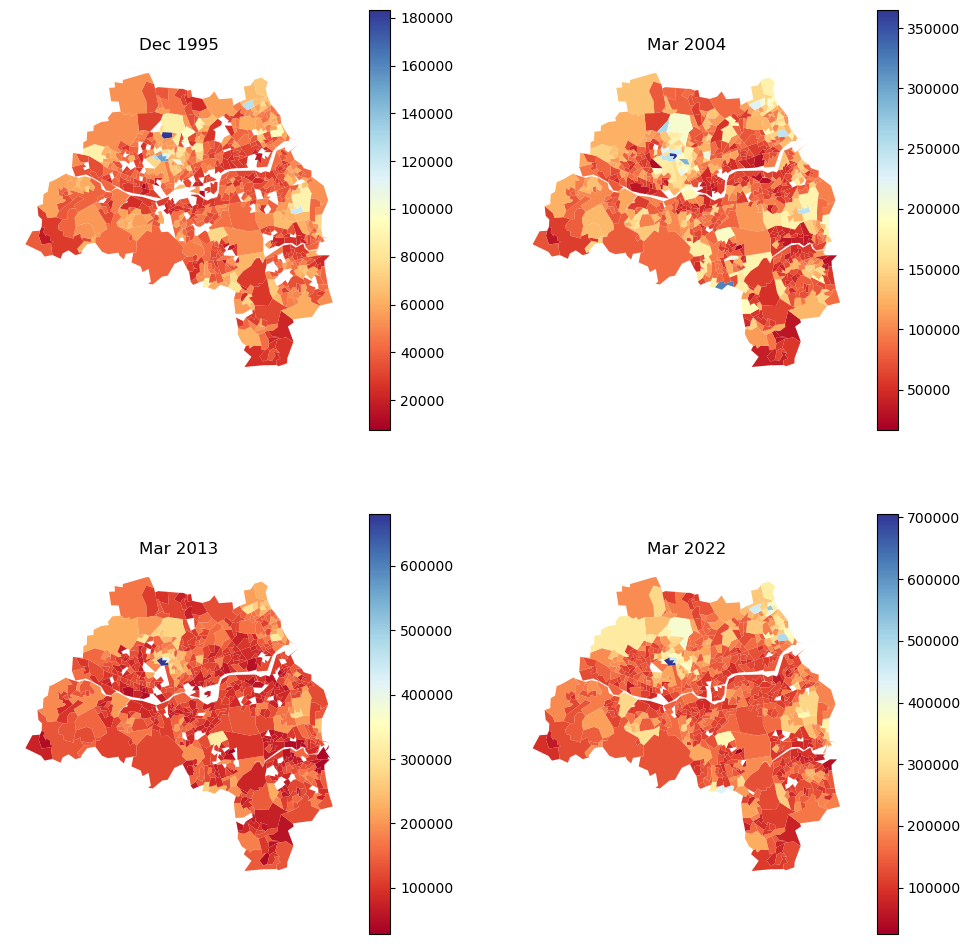

In [32]:
# plotting several years data on the same map
# more elegant solution here https://stackoverflow.com/questions/60821854/how-to-plot-a-geoplot-on-matplotlib-subplots
# also this solution interesting (they only have 3 columns?) https://plotly.com/python/facet-plots/#choropleth-column-facets

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2,
                                             ncols=2,
                                             figsize=(12,12))
lsoa_gdf_region_with_houseprice.plot(
    column="Year ending Dec 1995",
    ax=ax1,
    legend=True,
    # scheme='percentiles',
    cmap='RdYlBu',
)
ax1.set_title('Dec 1995')
lsoa_gdf_region_with_houseprice.plot(
    column="Year ending Mar 2004",
    ax=ax2,
    legend=True,
    # scheme='quantiles',
    cmap='RdYlBu',
)
ax2.set_title('Mar 2004')
lsoa_gdf_region_with_houseprice.plot(
    column="Year ending Mar 2013",
    ax=ax3,
    legend=True,
    # scheme='quantiles',
    cmap='RdYlBu',
)
ax3.set_title('Mar 2013')
lsoa_gdf_region_with_houseprice.plot(
    column="Year ending Mar 2022",
    ax=ax4,
    legend=True,
    # scheme='quantiles',
    cmap='RdYlBu',
)
ax4.set_title('Mar 2022')
for ax in (ax1,ax2,ax3,ax4):
    ax.axis('off')



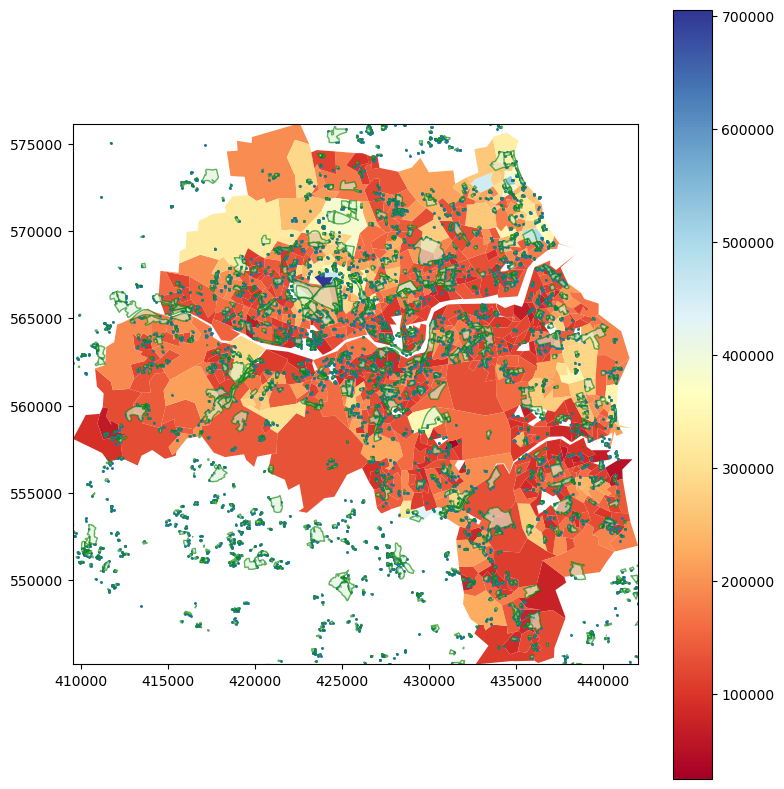

In [46]:
# plotting greenspace on top of the house price map
f, ax = plt.subplots(figsize=(8,8))
# setting the limits of figure to the region level (https://stackoverflow.com/questions/46477018/zooming-and-saving-only-a-central-part-of-interest-in-a-matplotlib-geopandas-fig)
minx, miny, maxx, maxy = lsoa_gdf_region_with_houseprice.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
lsoa_gdf_region_with_houseprice.plot(ax=ax,
                                     column="Year ending Mar 2022",
                                     cmap="RdYlBu",
                                     legend=True)
accesspoints_gs.plot(ax=ax,
                    #  edgecolor="y", #for yellow
                    markersize=5,
                    marker=".")
greenspace.plot(ax=ax,
                alpha=0.6,
                cmap="Greens",
                edgecolor="g") #for green
plt.tight_layout()

# takes long to plot, think of a way to "zoom in" the green space data in other way
# either select region earlier on, or extract data from the main file

**4. Results export**

In [61]:
# lsoa_gdf_region_with_houseprice.to_file(os.path.join(output_folder,
#                                                      "house_price_lsoa.shp"))
# getting an error probably due to the column names in the gdf
# trying to change them:

lsoa_gdf_region_with_houseprice.columns
lsoa_gdf_region_with_houseprice.columns = lsoa_gdf_region_with_houseprice.columns.str.replace("Year ending ", "")
lsoa_gdf_region_with_houseprice.columns

lsoa_gdf_region_with_houseprice.to_file(os.path.join(output_folder,
                                                     "house_price_lsoa.shp"))


/usr/local/anaconda3/envs/demoland/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  # This is added back by InteractiveShellApp.init_path()
